In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [2]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/GANSimForAllConditioning_20250718/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/Mud_drape_Channels/PreparedDataset/'

In [4]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
pb_cf_ratio_test = (labels_test[:,0] /2 +0.5) * (2-0.2) + 0.2  # point bar-to-channel fill ratio
fp_prop_test = (labels_test[:,1] / 2 + 0.5) * (0.82- 0.5) + 0.5   # floodplain proportion

print(facies_test.shape)
print(pb_cf_ratio_test.shape)
print(fp_prop_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000,)
(1000,)


(array([  1.,   0.,   1.,   1.,   1.,   1.,   2.,   5.,   3.,   3.,   6.,
          9.,  10.,  18.,  19.,  22.,  22.,  29.,  42.,  46.,  62.,  58.,
         70.,  85.,  75.,  81., 122., 102.,  82.,  22.]),
 array([0.43652344, 0.44934896, 0.46217448, 0.475     , 0.4878255 ,
        0.50065106, 0.51347655, 0.5263021 , 0.5391276 , 0.55195314,
        0.5647786 , 0.5776042 , 0.59042966, 0.6032552 , 0.6160807 ,
        0.62890625, 0.6417318 , 0.6545573 , 0.66738284, 0.6802083 ,
        0.6930339 , 0.70585936, 0.7186849 , 0.7315104 , 0.74433595,
        0.75716144, 0.769987  , 0.7828125 , 0.795638  , 0.8084635 ,
        0.82128906], dtype=float32),
 <a list of 30 Patch objects>)

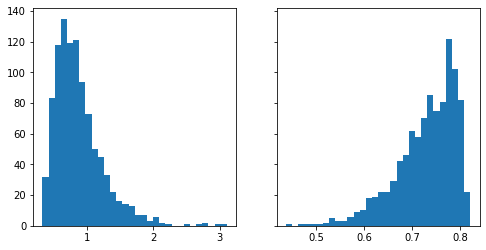

In [5]:
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(8, 4, forward=True)

axes[0].hist(pb_cf_ratio_test, bins = 30)
axes[1].hist(fp_prop_test, bins = 30)


### 2. Train and load trained unconditional generator

In [6]:
# Load trained generator

generator_dir = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/002-proguncond_2gpu_follow001/'
generator_name = 'network-snapshot-028481.pkl' 

tf.InteractiveSession()
with tf.device('/gpu:0'):   
    # Import networks.
    with open(generator_dir+generator_name, 'rb') as file:
        _, _, Gs_unc = pickle.load(file)     

print(Gs_unc.input_shapes)
print(Gs_unc.output_shapes)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 8, 4, 4], [None, 0, 4, 4], [None, 0, 64, 64], [None, 0, 64, 64]]
[[None, 4, 64, 64]]


### 3. Evaluate the trained generator by visually comparing test and generated facies models

#### Visualize random test facies models

In [7]:
# In the test and training facies models, the facies codes are 0, 1, 3, and 4, corresponding to the four facies types.
# The generator produces facies indicator models, which are then converted into facies models using an argmax function.
# As a result, the generated facies models have codes 0, 1, 2, and 3.
# To facilitate comparison between the test and generated facies models, the test facies codes are also remapped to 0, 1, 2, and 3.

facies_test_ = np.where(facies_test>2, facies_test - 1, facies_test)

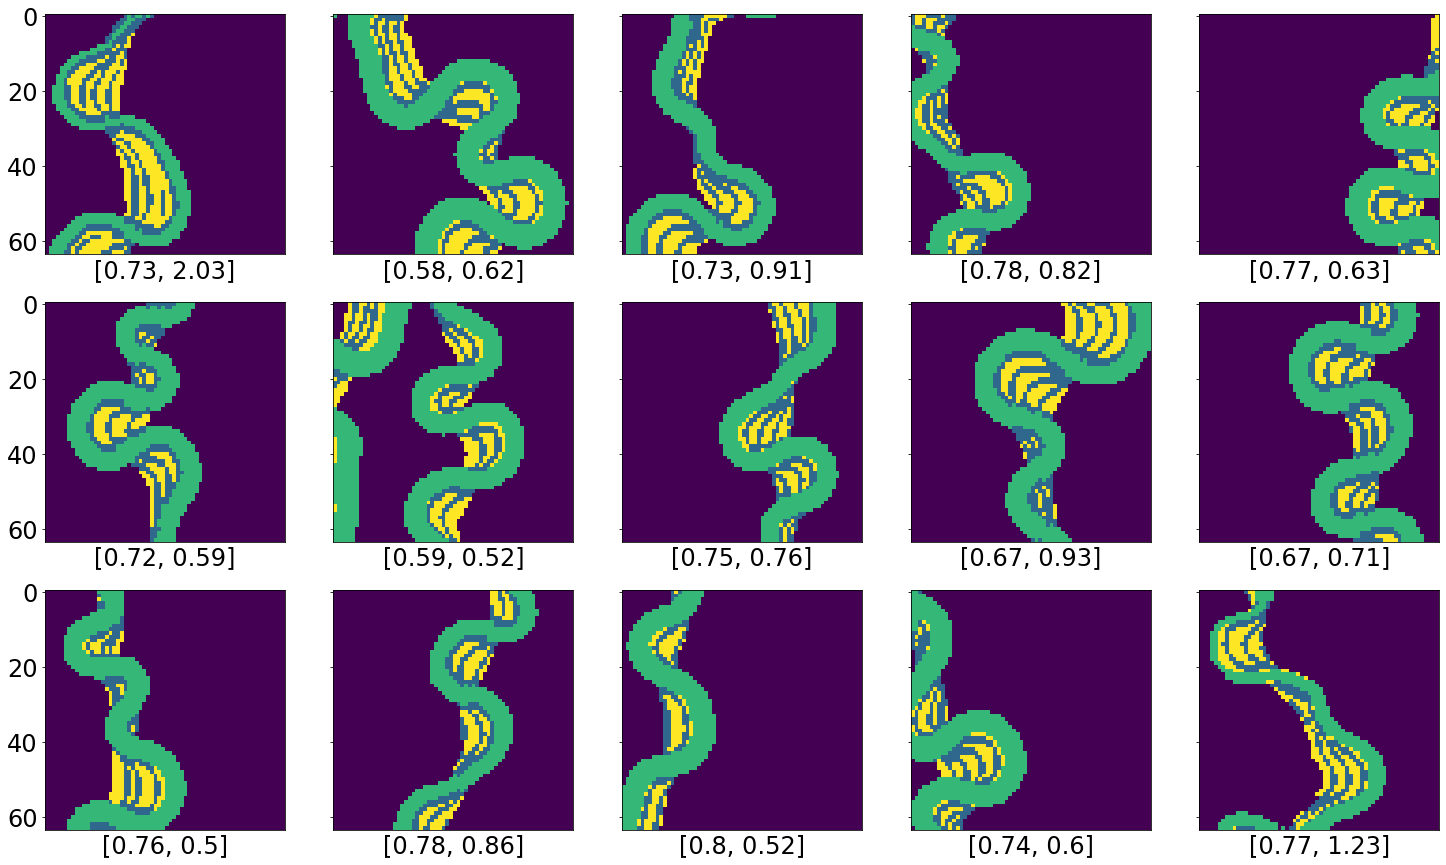

In [8]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(facies_test_[j,0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(fp_prop_test[j], 2))}, {str(round(pb_cf_ratio_test[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(facies_test_[j+15,0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(fp_prop_test[j+15], 2))}, {str(round(pb_cf_ratio_test[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(facies_test_[j+25,0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(fp_prop_test[j+25], 2))}, {str(round(pb_cf_ratio_test[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    
#plt.savefig(mcmc_dir + "Random_15TestFaciesMaps_1.jpg", dpi=200)     

#### Randomly generate using the trained unconditional generator and visualize facies models

In [9]:
# randomly generate 1000 facies models from the unconditional generator

TotalModel_no = 1000
fakemodel_indicators = np.zeros([TotalModel_no, 4, 64, 64])
latents = np.random.RandomState(41).randn(TotalModel_no, 8, 4, 4)
labels = np.zeros((TotalModel_no, 0, 4, 4))
wellfacies = np.zeros((TotalModel_no, 0, 64, 64)) 
prob = np.zeros((TotalModel_no, 0, 64, 64)) 
fakemodel_indicators = Gs_unc.run(latents, labels, wellfacies, prob) # facies indicator models for the four facies types
   
print(fakemodel_indicators.shape)

fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1) # argmax function to obtain facies models
print(fakemodels.shape)

(1000, 4, 64, 64)
(1000, 1, 64, 64)


In [10]:
# calculate the global features for the 1000 generated facies models

fp_prop_gen = np.mean(fakemodel_indicators[:, 0], axis = (1, 2))
md_prop_gen = np.mean(fakemodel_indicators[:, 1], axis = (1, 2))
cf_prop_gen = np.mean(fakemodel_indicators[:, 2], axis = (1, 2))
sd_prop_gen = np.mean(fakemodel_indicators[:, 3], axis = (1, 2))

# point bar (lump mud drape and sand together as one) to channel fill ratio
pb_cf_ratio_gen = (md_prop_gen + sd_prop_gen) / cf_prop_gen  


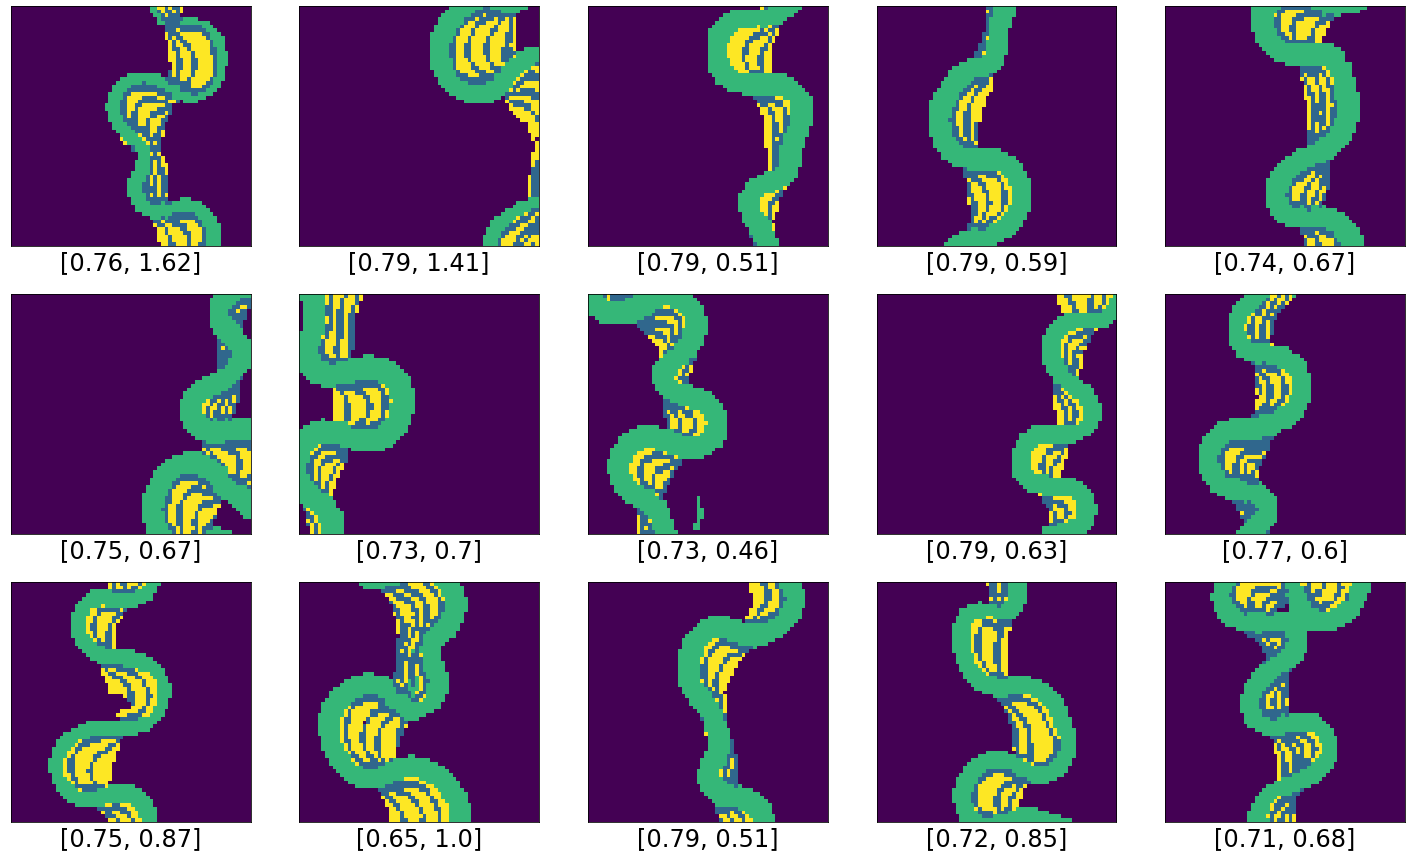

In [11]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(fakemodels[j,0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(fp_prop_gen[j], 2))}, {str(round(pb_cf_ratio_gen[j], 2))}]') 
    ax[0, j].set_yticks([])  # Remove x-axis markers
for j in range(5):
    ax[1, j].imshow(fakemodels[j+10,0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(fp_prop_gen[j+10], 2))}, {str(round(pb_cf_ratio_gen[j+10], 2))}]') 
    ax[1, j].set_yticks([])  # Remove x-axis markers
for j in range(5):
    ax[2, j].imshow(fakemodels[j+25,0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(fp_prop_gen[j+25], 2))}, {str(round(pb_cf_ratio_gen[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    ax[2, j].set_yticks([])  # Remove x-axis markers
    
#plt.savefig(mcmc_dir + "Random_15_GeneatedFaciesMaps_2.jpg", dpi=200)     

### 4. Quantitatively evaluate the unconditional generator

##### 4.1 Facies proportion histograms

In [12]:
fakemodels_md_prop = np.mean(np.where(fakemodels == 1, 1, 0), axis = (1, 2, 3)) # mud drape
fakemodels_cf_prop = np.mean(np.where(fakemodels == 2, 1, 0), axis = (1, 2, 3)) # channel fill
fakemodels_la_prop = np.mean(np.where(fakemodels == 3, 1, 0), axis = (1, 2, 3)) # lateral accretion
fakemodels_fp_prop = 1 - fakemodels_md_prop - fakemodels_cf_prop - fakemodels_la_prop # floodplain

realimgs_test_md_prop = np.mean(np.where(facies_test_ == 1, 1, 0), axis = (1, 2, 3)) # 
realimgs_test_cf_prop = np.mean(np.where(facies_test_ == 2, 1, 0), axis = (1, 2, 3)) # 
realimgs_test_la_prop = np.mean(np.where(facies_test_ == 3, 1, 0), axis = (1, 2, 3)) # 
realimgs_test_fp_prop = 1 - realimgs_test_md_prop - realimgs_test_cf_prop - realimgs_test_la_prop

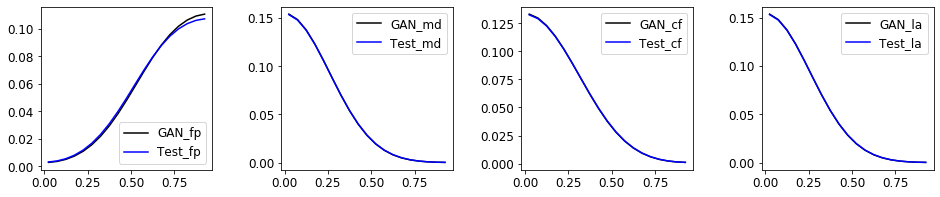

In [13]:
import scipy

bins_fp=np.arange(0.0,1.,0.05)
counts_fake_fp, bin_edges_fp = np.histogram(fakemodels_fp_prop, bins=bins_fp)
counts_fake_fp = counts_fake_fp / 1000.
fakemodels_fp_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_fp, sigma=5)
counts_real_fp, bin_edges_fp = np.histogram(realimgs_test_fp_prop, bins=bins_fp)
counts_real_fp = counts_real_fp / 1000.
realimgs_test_fp_prop_sm = scipy.ndimage.gaussian_filter(counts_real_fp, sigma=5)

bins_md=np.arange(0.0,1.,0.05)
counts_fake_md, bin_edges_md = np.histogram(fakemodels_md_prop, bins=bins_md)
counts_fake_md = counts_fake_md / 1000.
fakemodels_md_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_md, sigma=5)
counts_real_md, bin_edges_md = np.histogram(realimgs_test_md_prop, bins=bins_md)
counts_real_md = counts_real_md / 1000.
realimgs_test_md_prop_sm = scipy.ndimage.gaussian_filter(counts_real_md, sigma=5)

bins_cf=np.arange(0.0,1.,0.05)
counts_fake_cf, bin_edges_cf = np.histogram(fakemodels_cf_prop, bins=bins_cf)
counts_fake_cf = counts_fake_cf / 1000.
fakemodels_cf_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_cf, sigma=5)
counts_real_cf, bin_edges_cf = np.histogram(realimgs_test_cf_prop, bins=bins_cf)
counts_real_cf = counts_real_cf / 1000.
realimgs_test_cf_prop_sm = scipy.ndimage.gaussian_filter(counts_real_cf, sigma=5)

bins_la=np.arange(0.0,1.,0.05)
counts_fake_la, bin_edges_la = np.histogram(fakemodels_la_prop, bins=bins_la)
counts_fake_la = counts_fake_la / 1000.
fakemodels_la_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_la, sigma=5)
counts_real_la, bin_edges_la = np.histogram(realimgs_test_la_prop, bins=bins_la)
counts_real_la = counts_real_la / 1000.
realimgs_test_la_prop_sm = scipy.ndimage.gaussian_filter(counts_real_la, sigma=5)

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(16, 3, forward=True)

axes[0].plot((bin_edges_fp[1:] + bin_edges_fp[:-1])/2, fakemodels_fp_prop_sm, color='k', label = 'GAN_fp')
axes[0].plot((bin_edges_fp[1:] + bin_edges_fp[:-1])/2, realimgs_test_fp_prop_sm, color='blue', label = 'Test_fp')
axes[1].plot((bin_edges_md[1:] + bin_edges_md[:-1])/2, fakemodels_md_prop_sm, color='k', label = 'GAN_md')
axes[1].plot((bin_edges_md[1:] + bin_edges_md[:-1])/2, realimgs_test_md_prop_sm, color='blue', label = 'Test_md')
axes[2].plot((bin_edges_cf[1:] + bin_edges_cf[:-1])/2, fakemodels_cf_prop_sm, color='k', label = 'GAN_cf')
axes[2].plot((bin_edges_cf[1:] + bin_edges_cf[:-1])/2, realimgs_test_cf_prop_sm, color='blue', label = 'Test_cf')
axes[3].plot((bin_edges_la[1:] + bin_edges_la[:-1])/2, fakemodels_la_prop_sm, color='k', label = 'GAN_la')
axes[3].plot((bin_edges_la[1:] + bin_edges_la[:-1])/2, realimgs_test_la_prop_sm, color='blue', label = 'Test_la')


plt.rcParams.update({'font.size': 12})
axes[0].legend(loc='lower right') 
axes[1].legend(loc='upper right') 
axes[2].legend(loc='upper right')
axes[3].legend(loc='upper right')

plt.subplots_adjust(wspace=0.4)  # Increase this value for more space

#plt.savefig(generator_dir + "Facies proportion histogram comparison.jpg", dpi=200)     

##### 4.2 Global feature histograms

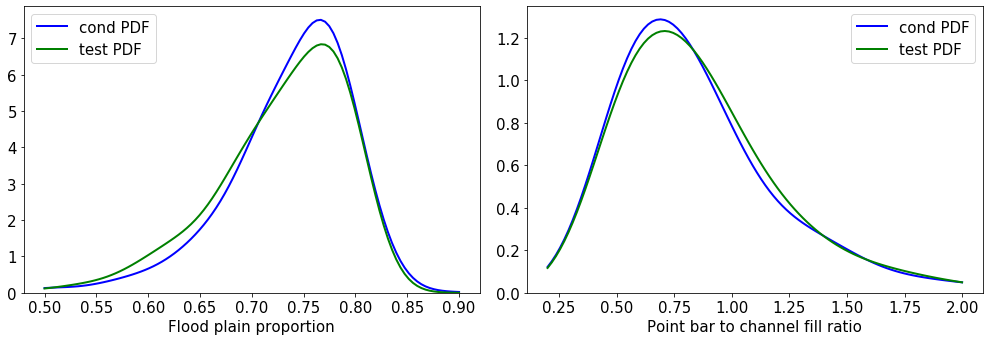

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

# ---- Flood plain proportion ----
x_range = np.linspace(0.5, 0.9, 100)
kde_cond_gen = gaussian_kde(fp_prop_gen, bw_method=0.4)
pdf_values_cond_gen = kde_cond_gen(x_range)
kde = gaussian_kde(fp_prop_test, bw_method=0.4)
pdf_values = kde(x_range)

ax[0].plot(x_range, pdf_values_cond_gen, 'blue', linewidth=2, label='cond PDF')
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='test PDF')
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Flood plain proportion')
ax[0].legend(loc='upper left')

# ---- Point bar to channel fill ratio ----
x_range = np.linspace(0.2, 2.0, 100)
kde_cond_gen = gaussian_kde(pb_cf_ratio_gen, bw_method=0.4)
pdf_values_cond_gen = kde_cond_gen(x_range)
kde = gaussian_kde(pb_cf_ratio_test, bw_method=0.4)
pdf_values = kde(x_range)

ax[1].plot(x_range, pdf_values_cond_gen, 'blue', linewidth=2, label='cond PDF')
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='test PDF')
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Point bar to channel fill ratio')
ax[1].legend(loc='upper right')

plt.subplots_adjust(wspace=0.25)
plt.tight_layout()
# plt.savefig(generator_dir + "GlobalFeatures_histograms.jpg", dpi=100)


##### 4.3 MDS plots

###### MDS plot based on Sliced Wasserstein Distance (SWD) calculated from multiscale pyramids

In [18]:
from scipy import signal
from scipy.ndimage.filters import convolve
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import kde
import scipy.ndimage

gaussian_filter = np.float32([
    [1, 4,  6,  4,  1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4,  6,  4,  1]]) / 256.0

def pyr_down(minibatch): # matches cv2.pyrDown()
    assert minibatch.ndim == 4
    return scipy.ndimage.convolve(minibatch, gaussian_filter[np.newaxis, np.newaxis, :, :], mode='mirror')[:, :, ::2, ::2]

def pyr_up(minibatch): # matches cv2.pyrUp()
    assert minibatch.ndim == 4
    S = minibatch.shape
    res = np.zeros((S[0], S[1], S[2] * 2, S[3] * 2), minibatch.dtype)
    res[:, :, ::2, ::2] = minibatch
    return scipy.ndimage.convolve(res, gaussian_filter[np.newaxis, np.newaxis, :, :] * 4.0, mode='mirror')

def generate_laplacian_pyramid(minibatch, num_levels):
    pyramid = [np.float32(minibatch)]
    for i in range(1, num_levels):
        pyramid.append(pyr_down(pyramid[-1]))
        pyramid[-2] -= pyr_up(pyramid[-1])
    return pyramid

def get_descriptors_for_minibatch(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, channel, height, width)
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, chan, x, y = np.ogrid[0:N, 0:1, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[3] - H, size=(N, 1, 1, 1))
    y = y + np.random.randint(H, S[2] - H, size=(N, 1, 1, 1))
    idx = ((img * S[1] + chan) * S[2] + y) * S[3] + x
    return minibatch.flat[idx]

# Only extract descriptors at values > 0.3 
def get_descriptors_for_minibatch_indc(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, channel, height, width)
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2

    minibatch_ = np.zeros(minibatch.shape)
    minibatch_[:,:, H : S[2] - H, H : S[3] - H] = minibatch[:,:, H : S[2] - H, H : S[3] - H]
    one_coos = np.argwhere(minibatch_>=0.2)
    center_index = np.random.randint(0, one_coos.shape[0], N)    
    center_coos = one_coos[center_index]
    desc = np.zeros((N, 1, nhood_size, nhood_size))
    for i in range(N):
        desc[i] = minibatch[center_coos[i, 0], 0, center_coos[i, 2] - H: center_coos[i, 2] + H + 1, center_coos[i, 3] - H: center_coos[i, 3] + H + 1]
    return desc

def finalize_descriptors(desc):
    if isinstance(desc, list):
        desc = np.concatenate(desc, axis=0)
    assert desc.ndim == 4 # (neighborhood, channel, height, width)
    desc -= np.mean(desc, axis=(0, 2, 3), keepdims=True)
    desc /= np.std(desc, axis=(0, 2, 3), keepdims=True)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def sliced_wasserstein(A, B, dir_repeats, dirs_per_repeat):
    assert A.ndim == 2 and A.shape == B.shape                           # (neighborhood, descriptor_component)
    results = []
    for repeat in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)             # (descriptor_component, direction)
        dirs /= np.sqrt(np.sum(np.square(dirs), axis=0, keepdims=True)) # normalize descriptor components for each direction
        dirs = dirs.astype(np.float32)
        projA = np.matmul(A, dirs)                                      # (neighborhood, direction)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)                                  # sort neighborhood projections for each direction
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)                                   # pointwise wasserstein distances
        results.append(np.mean(dists))                                  # average over neighborhoods and directions
    return np.mean(results)                                             # average over repeats


In [19]:
def indicatorize(facies_img, codes):
    s = facies_img.shape
    ind_imgs = np.zeros((s[0], 0, s[2], s[3]), np.float32)
    for code in codes:
        ind_imgs = np.concatenate([ind_imgs, np.where(facies_img == code, 1, 0)], axis = 1)
    return ind_imgs

def convert_to_matrix(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    np.transpose(out)[mask] = a        
    return out 

In [22]:
def plot_samples(axis, swd_matrix):
    mds = manifold.MDS(n_components=2, max_iter=6000, eps=1e-19, dissimilarity="precomputed", n_jobs=1)
    coos = mds.fit(swd_matrix).embedding_
            
    x_test_co = coos[:mds_grps, 0]
    y_test_co = coos[:mds_grps, 1]
    x_produced_co = coos[mds_grps:mds_grps+mds_grps, 0]
    y_produced_co = coos[mds_grps:mds_grps+mds_grps, 1]  
            
    plot_lim_min = -0.4
    plot_lim_max = 0.4

    ax_left = axis.inset_axes([0., 0., 0.47, 1])
    ax_right = axis.inset_axes([0.53, 0., 0.47, 1])
    
    ax_left.set(xticks=[-0.5, 0, 0.5], yticks=[-0.6, -0.3, 0, 0.3, 0.6])  # remove the tick lab    
    ax_right.tick_params(left=False)  # remove the ticks
    ax_right.set(xticks=[-0.5, 0, 0.5], yticklabels=[])  # remove the tick lab
    
    #ax_left.set_title('Scatterplot')
    ax_left.set_xlim([plot_lim_min, plot_lim_max])
    ax_left.set_ylim([plot_lim_min, plot_lim_max])        
    ax_left.plot(x_test_co, y_test_co, 'ro', label = 'Test')
    ax_left.plot(x_produced_co, y_produced_co, 'b+', label = 'Generated')
    ax_left.legend(loc='upper right')
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 40
    k_test = kde.gaussian_kde((coos.T[:, :mds_grps]))
    xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
    zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
    ax_right.set_xlim([plot_lim_min, plot_lim_max])
    ax_right.set_ylim([plot_lim_min, plot_lim_max])                
    test_contr = ax_right.contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='r', label = 'Test') 
    
    k_produced = kde.gaussian_kde((coos.T[:, mds_grps:mds_grps+mds_grps]))
    xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
    zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
    produced_contr = ax_right.contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated') 
            
    test_contr.collections[0].set_label('Test')
    produced_contr.collections[0].set_label('Generated')
            
    #ax_right.set_title('Densityplot')
    ax_right.legend(loc='upper right') 

In [23]:
test_mds_num = 90  # total number
prod_mds_num = 90
mds_grps = 30  # groups, each group contain multiple facies models, each group corresponds to one point
num_per_grp = int(test_mds_num / mds_grps)
codes = [0, 1, 2, 3]
codes_swd_w = [1/4., 1/4., 1/4., 1/4.]
nhood_sizes = [5, 5, 5]    # neighborhood size, 5x5x5
nhoods_per_image   = 24
dir_repeats        = 4
dirs_per_repeat    = 64
resolutions = [64, 32, 16]  # pyramid resolutions

In [25]:
test_indicators_mds = indicatorize(facies_test_[0:0+test_mds_num], codes) # np.tile(indicatorize(facies_test[0:0+2], codes), (int(prod_mds_num/2), 1, 1, 1, 1)) # 
prod_indicators_mds = fakemodel_indicators[0:0+prod_mds_num]
all_indicators_mds = np.squeeze(np.concatenate((test_indicators_mds, prod_indicators_mds), axis = 0))  # shape [251, 64, 64, 64]
#all_indicators_mds = np.expand_dims(all_indicators_mds, axis = 1)

kk = np.tril(np.ones((mds_grps * 2, mds_grps * 2)), -1)  
coor = np.argwhere(kk > 0)
list_1 = coor[:, 0]
list_2 = coor[:, 1] 

swd_matrix_list_64 = []  # swd_matrix for different codes
swd_matrix_list_32 = []  # swd_matrix for different codes
swd_matrix_list_16 = []  # swd_matrix for different codes

for j in range(len(codes)):
    groups_lap = []
    for i in range(mds_grps * 2):
        descriptors = [[] for res in resolutions]
        m = 0
        for lod, level in enumerate(generate_laplacian_pyramid(all_indicators_mds[i * num_per_grp : (i+1) * num_per_grp, j:j+1], len(resolutions))):
            desc = get_descriptors_for_minibatch(level, nhood_sizes[m], nhoods_per_image)
            descriptors[lod].append(desc)
            m = m + 1
        groups_lap.append(descriptors)

    gr_swd_64 = []
    gr_swd_32 = []
    gr_swd_16 = []
    for gr in range(list_1.shape[0]):
        desc_1 = [finalize_descriptors(d) for d in groups_lap[list_1[gr]]]
        desc_2 = [finalize_descriptors(d) for d in groups_lap[list_2[gr]]]
        slw = [sliced_wasserstein(dreal, dfake, dir_repeats, dirs_per_repeat) for dreal, dfake in zip(desc_1, desc_2)]

        gr_swd_64.append(slw[0]) #np.mean(slw))
        gr_swd_32.append(slw[1]) #np.mean(slw))
        gr_swd_16.append(slw[2]) #np.mean(slw))
 
    swd_matrix_list_64.append(convert_to_matrix(gr_swd_64))
    swd_matrix_list_32.append(convert_to_matrix(gr_swd_32))
    swd_matrix_list_16.append(convert_to_matrix(gr_swd_16))

In [26]:
swd_matrix_list_mean_code0 = (swd_matrix_list_64[0] + swd_matrix_list_32[0] + swd_matrix_list_16[0])/3
swd_matrix_list_mean_code1 = (swd_matrix_list_64[1] + swd_matrix_list_32[1] + swd_matrix_list_16[1])/3
swd_matrix_list_mean_code2 = (swd_matrix_list_64[2] + swd_matrix_list_32[2] + swd_matrix_list_16[2])/3

swd_matrix_list_64_mean = (swd_matrix_list_64[0] + swd_matrix_list_64[1] + swd_matrix_list_64[2])/3 
swd_matrix_list_32_mean = (swd_matrix_list_32[0] + swd_matrix_list_32[1] + swd_matrix_list_32[2])/3 
swd_matrix_list_16_mean = (swd_matrix_list_16[0] + swd_matrix_list_16[1] + swd_matrix_list_16[2])/3 

swd_matrix_mean = (swd_matrix_list_mean_code0 + swd_matrix_list_mean_code1 + swd_matrix_list_mean_code2) / 3

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: The following kwargs were not used by contour: 'label'
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'label'


(0.0, 1.0, 0.0, 1.0)

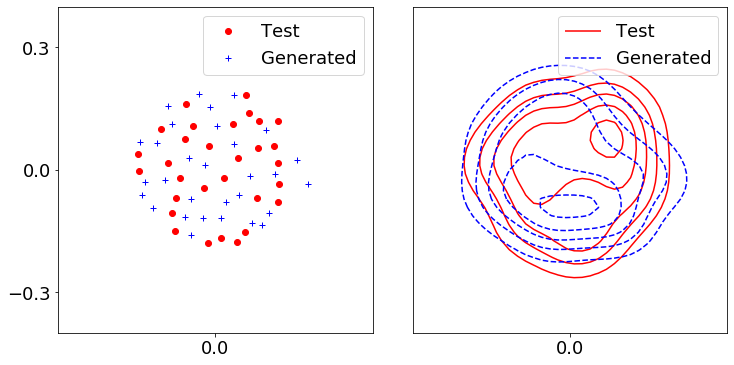

In [27]:
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(ncols=1, nrows=1, sharex='col', sharey='row')
fig.set_size_inches(12, 6, forward=True)
fig.subplots_adjust(wspace=0.1, hspace=0.2)

plot_samples(axes, swd_matrix_mean)

axes.axis('off') 

# Save the figure
#plt.savefig(generator_dir + "MDS plots.jpg", dpi=100)


### 5. Post-GANs (MCMC) for conditioning to given global features

*Assume the flood plain facies proportion and the point bar to channel fill ratio are 0.74 and 1.14*


#### 5.1. MCMC execution

In [32]:
from scipy.stats import multivariate_normal

labels_run = np.zeros((1, 0, 4, 4))
wellfacies_run = np.zeros((1, 0, 64, 64)) 
prob_run = np.zeros((1, 0, 64, 64)) 

def cal_lik_from_z(z):
    sigma_e = 0.01
    
    fakemodel_indicators = Gs_unc.run(z, labels_run, wellfacies_run, prob_run)  # [N, 4, 64, 64] indicators of flood plain, mud drape, channel fill, sand, in order
    fp_prop = np.mean(fakemodel_indicators[:, 0])
    md_prop = np.mean(fakemodel_indicators[:, 1])
    cf_prop = np.mean(fakemodel_indicators[:, 2])
    sd_prop = np.mean(fakemodel_indicators[:, 3])
    # point bar (lump mud drape and sand together as one) to channel fill ratio
    pb_cf_ratio = (md_prop + sd_prop) / cf_prop
    
    # 0.32 and 1.8 are the range of the two features
    dist = ((fp_prop - 0.74) / 0.32)**2 + ((pb_cf_ratio - 1.14)/1.8)**2 

    likelihood = 1 / (sigma_e * (2 * np.pi) ** 0.5) * np.exp(-0.5*(dist/sigma_e)**2)
    
    return likelihood, dist

def cal_prior(z):
    dim = np.prod(z.shape[1:])
    m = np.zeros(dim,)
    C = np.eye(dim)
    prior = multivariate_normal.pdf(z.reshape(-1),mean=m,cov=C)    
    return prior

import time
def latent_selection_mcmc(opt_max_num):  # , dist_thresh
    time_st = time.time()
    new_z_sigma = 0.06
    z_dim = [1] + Gs_unc.input_shapes[0][1:]
       
    latents = []
    dists = []
    times = []
       
    latent = np.random.randn(*z_dim) 
    likelihood, dist = cal_lik_from_z(latent)
    prior = cal_prior(latent)
    opt_num = 0
    while opt_num < opt_max_num: 
        
        latent_new = latent + np.random.normal(0, new_z_sigma, size=z_dim)
        likelihood_new, dist_new = cal_lik_from_z(latent_new)
        prior_new = cal_prior(latent_new)
        
        rho = min(1, likelihood_new / likelihood * (prior_new / prior))
        
        u = np.random.uniform()
        if u < rho:
            latent = latent_new
            likelihood = likelihood_new
            dist = dist_new
            prior = prior_new           
           # if dist < dist_thresh:   
            latents.append(latent)
            dists.append(dist)
            time_ed = time.time()
            times.append(time_ed - time_st) 
            time_st = time.time()
                    
        opt_num = opt_num + 1  
    
    return latents, dists, times


In [33]:
chain_no = 10  # MCMC chain number 
opt_max_num = 50000  
# dist_thresh = 0.2  # 0.12

latents_mul_chain = []
dists_mul_chain = []
times_mul_chain = []
chain_count = []

time_mcmc_st = time.time()
for i in range(chain_no):  
    print(i)
    latents, dists, times = latent_selection_mcmc(opt_max_num)
    latents_mul_chain = latents_mul_chain + latents 
    dists_mul_chain = dists_mul_chain + dists
    times_mul_chain = times_mul_chain + times
    latents_no = len(dists)
    chain_count = chain_count + ([i + 1] * latents_no)
time_mcmc_ed = time.time()
time_mcmc_whole = time_mcmc_ed - time_mcmc_st
print(time_mcmc_whole)

total_latent_no = len(dists_mul_chain)
converg_info = np.zeros((total_latent_no, 131))
converg_info[:,0] = np.array(chain_count)
converg_info[:,1] = np.array(times_mul_chain)
converg_info[:,2] = np.array(dists_mul_chain)
converg_info[:,3:] = np.array(latents_mul_chain)[:,0,:].reshape(-1, 128)

mcmc_dir = '/scratch/users/suihong/Mud_drape_Channels/MCMCForGlobalFeatureConditioning/'
mcmc_convg_info_fname = mcmc_dir + 'MCMC_Fluvial_10chainx50kiter_sig_p01.txt'
np.savetxt(mcmc_convg_info_fname, converg_info, fmt= '%i ' + '%4.3f ' + '%3.3f '  + "%1.8f " * 128, newline='\n')  

0
1


KeyboardInterrupt: 

#### 5.2. Evaluation of MCMC results

*Import accepted latent vectors obtained from MCMC*

In [34]:
mcmc_dir = '/scratch/users/suihong/Mud_drape_Channels/MCMCForGlobalFeatureConditioning/'
mcmc_convg_info_fname =  mcmc_dir + "MCMC_Fluvial_10chainx50kiter_sig_p01.txt"

allele=[] 
with open(mcmc_convg_info_fname, 'r') as f:
    for line in f:
        eles = line.strip().split(' ')
        allele.append(eles)

converg_info = np.array(allele, dtype = float).reshape((-1, 131))
print(converg_info.shape)

(309657, 131)


In [35]:
converg_chains = converg_info[:, 0]
converg_times = converg_info[:, 1]
converg_dists = converg_info[:, 2]
converg_latents = converg_info[:,3:].reshape(-1, 8, 4, 4)

print(converg_latents.shape)
print(np.average(converg_dists))
print(np.average(converg_times))

(309657, 8, 4, 4)
0.007672398815463561
0.008377323942297444


*Only choose samples with convergence distances smaller than 0.015*

In [36]:
all_chain_dist_ord = np.argwhere(converg_dists<0.015)[:, 0]
converg_dists_all_chains = converg_dists[all_chain_dist_ord]
converg_latents_all_chains = converg_latents[all_chain_dist_ord]#converg_latents[all_chain_dist_ord[:2000]]
print(converg_latents_all_chains.shape)

(268420, 8, 4, 4)


*Randomly sample 200 samples from these accepted samples.*

(200, 8, 4, 4)


(array([ 9.,  0., 20.,  0.,  0., 28.,  0., 18.,  0.,  0., 16.,  0., 17.,
         0.,  0., 16.,  0., 14.,  0.,  0.,  7.,  0., 16.,  0.,  0., 10.,
         0.,  7.,  0.,  0., 10.,  0.,  6.,  0.,  0.,  6.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124,
        0.0128, 0.0132, 0.0136, 0.014 , 0.0144, 0.0148, 0.0152, 0.0156,
        0.016 , 0.0164, 0.0168, 0.0172, 0.0176, 0.018 , 0.0184, 0.0188,
        0.0192, 0.0196, 0.02  ]),
 <a list of 50 Patch objects>)

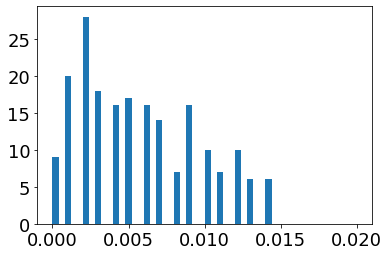

In [38]:
sample_numb = 200
random_index = np.random.RandomState(66).permutation(converg_latents_all_chains.shape[0])[:sample_numb]
sampled_latents_MCMC = converg_latents_all_chains[random_index]
sampled_dists_MCMC = converg_dists_all_chains[random_index]
print(sampled_latents_MCMC.shape)

plt.hist(sampled_dists_MCMC, bins = 50, range = (0, 0.02))



*Calculate facies models for the 200 randomly selected samples, and calculate the corresponding global features*


In [40]:
labels_run = np.zeros((sample_numb, 0, 4, 4))
wellfacies_run = np.zeros((sample_numb, 0, 64, 64)) 
prob_run = np.zeros((sample_numb, 0, 64, 64)) 

fakemodel_indicators = Gs_unc.run(sampled_latents_MCMC, labels_run, wellfacies_run, prob_run)
fakemodel_mcmc = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)  # [N, 1, 64, 64]
    
fp_prop_mcmc = np.mean(fakemodel_indicators[:, 0], axis = (1, 2))
md_prop_mcmc = np.mean(fakemodel_indicators[:, 1], axis = (1, 2))
cf_prop_mcmc = np.mean(fakemodel_indicators[:, 2], axis = (1, 2))
sd_prop_mcmc = np.mean(fakemodel_indicators[:, 3], axis = (1, 2))
# point bar (lump mud drape and sand together as one) to channel fill ratio
pb_cf_ratio_mcmc = (md_prop_mcmc + sd_prop_mcmc) / cf_prop_mcmc   




*Visualize the facies models conditioned to the given global features and the pdf of their global features*


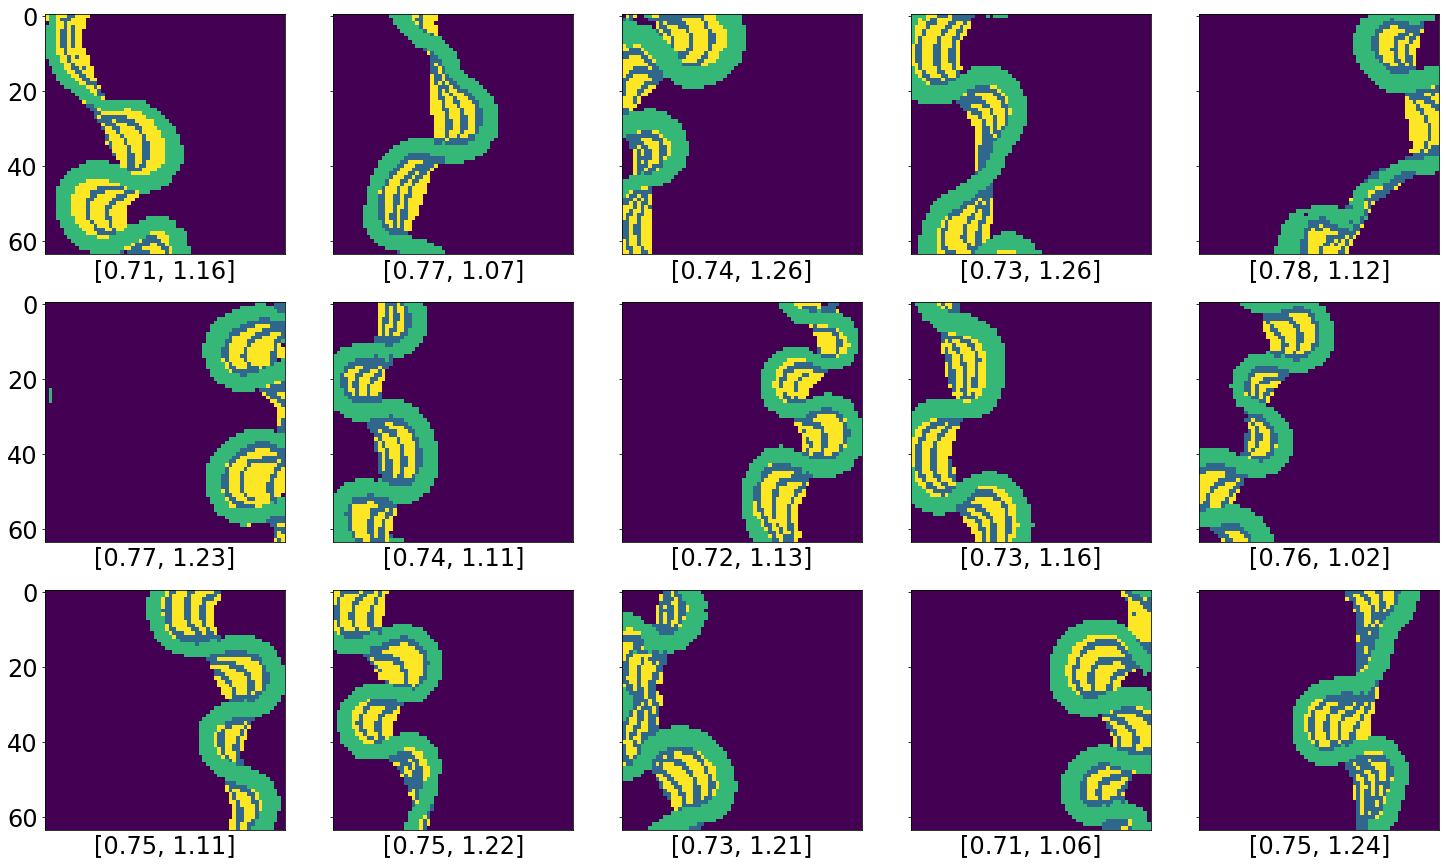

In [42]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(fakemodel_mcmc[j+5,0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(fp_prop_mcmc[j+5], 2))}, {str(round(pb_cf_ratio_mcmc[j+5], 2))}]') 
for j in range(5):
    ax[1, j].imshow(fakemodel_mcmc[j+15,0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(fp_prop_mcmc[j+15], 2))}, {str(round(pb_cf_ratio_mcmc[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(fakemodel_mcmc[j+25,0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(fp_prop_mcmc[j+25], 2))}, {str(round(pb_cf_ratio_mcmc[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    
#plt.savefig(mcmc_dir + "MCMC_10chain_thrshp015_random_15FaciesMaps_1.jpg", dpi=200)     

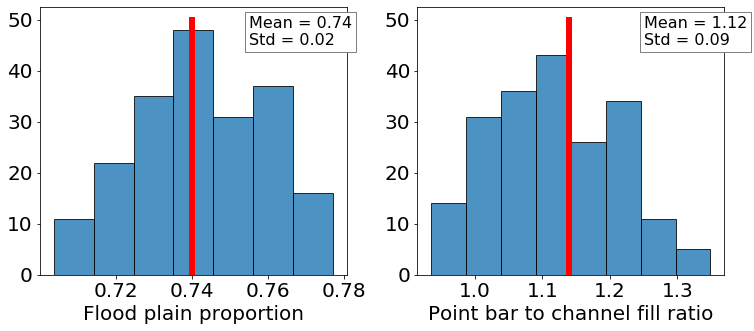

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11, 5)

# --- Plot Floodplain Proportion Histogram ---
mean_fp = np.mean(fp_prop_mcmc)
std_fp = np.std(fp_prop_mcmc)
ax[0].hist(fp_prop_mcmc, bins=7, alpha=0.8, histtype='bar', ec='black')
ax[0].plot([0.74, 0.74], [0, 50], 'r-', linewidth=6)
ax[0].set_xlabel('Flood plain proportion')
ax[0].text(0.755, 45, f'Mean = {mean_fp:.2f}\nStd = {std_fp:.2f}', fontsize=16, bbox=dict(facecolor='white', edgecolor='gray'))

# --- Plot Point Bar to Channel Fill Ratio Histogram ---
mean_pb = np.mean(pb_cf_ratio_mcmc)
std_pb = np.std(pb_cf_ratio_mcmc)
ax[1].hist(pb_cf_ratio_mcmc, bins=8, alpha=0.8, histtype='bar', ec='black')
ax[1].plot([1.14, 1.14], [0, 50], 'r-', linewidth=6)
ax[1].set_xlabel('Point bar to channel fill ratio')
ax[1].text(1.25, 45, f'Mean = {mean_pb:.2f}\nStd = {std_pb:.2f}', fontsize=16, bbox=dict(facecolor='white', edgecolor='gray'))

plt.subplots_adjust(wspace=0.25)
plt.tight_layout()

# Save the figure if needed
# plt.savefig(mcmc_dir + "MCMC_10chain_thrshp015_Geometrical_histograms.jpg", dpi=200, bbox_inches='tight')


